In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import tensorflow as tf
tf.compat.v1.enable_eager_execution
from keras.models import Model, load_model
from keras.layers import Lambda, Input, Dense, Dropout
from keras.losses import binary_crossentropy, kl_divergence
from keras.losses import MeanSquaredError as mse
from keras import optimizers

from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt

from argparse import Namespace
from pathlib import Path
from collections import OrderedDict
import sklearn
from sklearn import preprocessing
import os
import pickle
from utils.functions import sample, get_error_term
from model.vae_model import vae_model

In [2]:
raw_dt = pd.read_csv("data/realKnownCause/realKnownCause/machine_temperature_system_failure.csv")
# raw_dt = pd.read_csv(datafile_path)
raw_dt.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


Text(0.5, 1.0, 'Original Dataset')

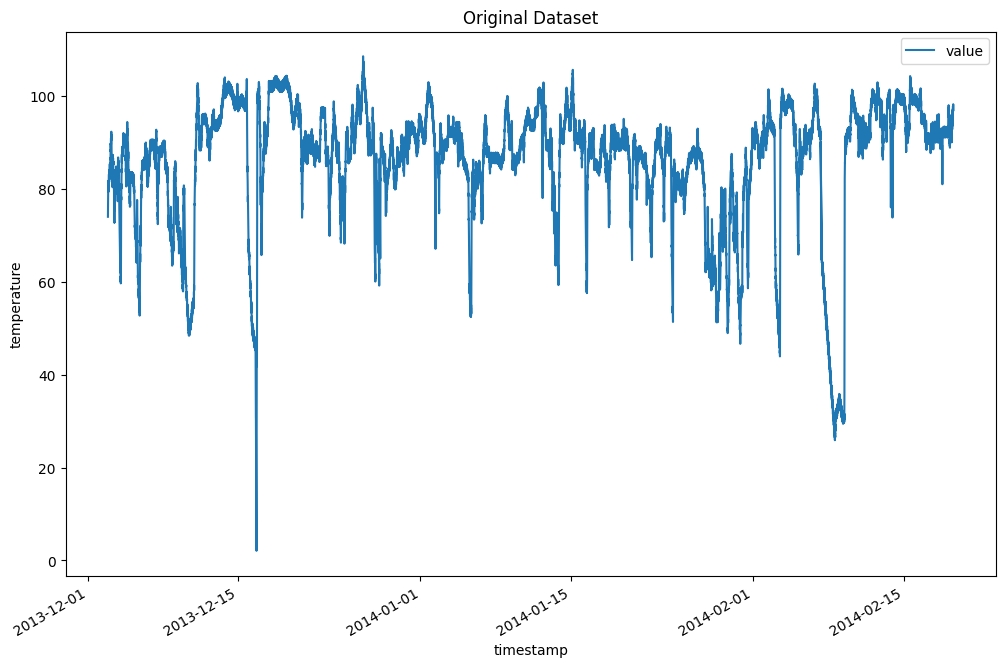

In [3]:
data = raw_dt.copy()
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.plot(x='timestamp', y='value', figsize=(12, 8))
plt.ylabel("temperature")
plt.title("Original Dataset")

In [4]:
data['label'] = 1
with open('lists.pkl', 'rb') as f:
    lists = pickle.load(f)

# Access the lists
instances= lists[0]


In [5]:
for i in range(len(instances)): 
    start = pd.to_datetime(instances[i][0])
    end = pd.to_datetime(instances[i][1])
    data.loc[(data['timestamp'] >= start) & (data['timestamp'] <= end), 'label'] = 0

In [6]:
data_w_ts=data.copy()
data_w_ts

,timestamp,value,label
0,2013-12-02 21:15:00,73.967322,1
1,2013-12-02 21:20:00,74.935882,1
2,2013-12-02 21:25:00,76.124162,1
3,2013-12-02 21:30:00,78.140707,1
4,2013-12-02 21:35:00,79.329836,1
...,...,...,...
22690,2014-02-19 15:05:00,98.185415,1
22691,2014-02-19 15:10:00,97.804168,1
22692,2014-02-19 15:15:00,97.135468,1
22693,2014-02-19 15:20:00,98.056852,1


In [7]:
data['day'] = data['timestamp'].dt.day
data['month'] = data['timestamp'].dt.month
data['hour_min'] = data['timestamp'].dt.hour + data['timestamp'].dt.minute / 60

data['day_of_week'] = data['timestamp'].dt.dayofweek
data['holiday'] = 0
data.loc[(data['day'] == 25) & (data['month'] == 12),'holiday'] = 1  # Christmas
data.loc[(data['day'] == 1) & (data['month'] == 1),'holiday'] = 1  # New Year's Day
data.head()

,timestamp,value,label,day,month,hour_min,day_of_week,holiday
0,2013-12-02 21:15:00,73.967322,1,2,12,21.250000,0,0
1,2013-12-02 21:20:00,74.935882,1,2,12,21.333333,0,0
2,2013-12-02 21:25:00,76.124162,1,2,12,21.416667,0,0
3,2013-12-02 21:30:00,78.140707,1,2,12,21.500000,0,0
4,2013-12-02 21:35:00,79.329836,1,2,12,21.583333,0,0


In [8]:
holidays = data.loc[data['holiday'] == 1, 'timestamp'].dt.date.unique()
holidays

array([datetime.date(2013, 12, 25), datetime.date(2014, 1, 1)],
      dtype=object)

In [9]:
for i, hd in enumerate(holidays):
    data['hol_' + str(i)] = data['timestamp'].dt.date - hd

In [10]:
for i in range(data.shape[0]):
    if np.abs(data.loc[data.index[i], 'hol_0']) <= np.abs(data.loc[data.index[i], 'hol_1']):
        data.loc[data.index[i], 'gap_holiday'] = data.loc[data.index[i], 'hol_0']
    else:
        data.loc[data.index[i], 'gap_holiday'] = data.loc[data.index[i], 'hol_1']

In [11]:
data['gap_holiday'] = data['gap_holiday'].dt.days
data.drop(['hol_0', 'hol_1'], axis=1, inplace=True)
data['t'] = (data['timestamp'].astype(np.int64)/1e11).astype(np.int64)
data.drop('timestamp', axis=1, inplace=True)
data

,value,label,day,month,hour_min,day_of_week,holiday,gap_holiday,t
0,73.967322,1,2,12,21.250000,0,0,-23,13860189
1,74.935882,1,2,12,21.333333,0,0,-23,13860192
2,76.124162,1,2,12,21.416667,0,0,-23,13860195
3,78.140707,1,2,12,21.500000,0,0,-23,13860198
4,79.329836,1,2,12,21.583333,0,0,-23,13860201
...,...,...,...,...,...,...,...,...,...
22690,98.185415,1,19,2,15.083333,2,0,49,13928223
22691,97.804168,1,19,2,15.166667,2,0,49,13928226
22692,97.135468,1,19,2,15.250000,2,0,49,13928229
22693,98.056852,1,19,2,15.333333,2,0,49,13928232


In [12]:
cont_vars = ['value', 'hour_min', 'gap_holiday', 't']
cat_vars = ['day', 'month', 'day_of_week', 'holiday']

In [13]:
from sklearn.preprocessing import LabelEncoder

# label_encoders = [LabelEncoder() for _ in cat_vars] 
# for col, enc in zip(cat_vars, label_encoders):
#     data[col] = enc.fit_transform(data[col])
    
data= pd.get_dummies(data.iloc[:,:], columns= cat_vars )
data

,value,label,hour_min,gap_holiday,t,day_1,day_2,day_3,day_4,day_5,...,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,holiday_0,holiday_1
0,73.967322,1,21.250000,-23,13860189,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
1,74.935882,1,21.333333,-23,13860192,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
2,76.124162,1,21.416667,-23,13860195,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
3,78.140707,1,21.500000,-23,13860198,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
4,79.329836,1,21.583333,-23,13860201,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22690,98.185415,1,15.083333,49,13928223,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
22691,97.804168,1,15.166667,49,13928226,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
22692,97.135468,1,15.250000,49,13928229,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
22693,98.056852,1,15.333333,49,13928232,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False


In [14]:
print(data.keys())

Index(['value', 'label', 'hour_min', 'gap_holiday', 't', 'day_1', 'day_2',
       'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10',
       'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17',
       'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24',
       'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30', 'day_31',
       'month_1', 'month_2', 'month_12', 'day_of_week_0', 'day_of_week_1',
       'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5',
       'day_of_week_6', 'holiday_0', 'holiday_1'],
      dtype='object')


In [15]:
# Splitting to train and test
test_ratio = 0.3
start = 0       # or int(len(data) * 0.25 )  # or 0 
tr_data = data.iloc[start: int(len(data) * (1 - test_ratio))]
tst_data = data.iloc[int(len(data) * (1 - test_ratio)) :]

In [16]:
scaler = preprocessing.StandardScaler().fit(tr_data[cont_vars])

In [17]:
tr_data_scaled = tr_data.copy()
tr_data_scaled[cont_vars] = scaler.transform(tr_data[cont_vars])
tst_data_scaled = tst_data.copy()
tst_data_scaled[cont_vars] = scaler.transform(tst_data[cont_vars])

In [18]:
tr_data_scaled

,value,label,hour_min,gap_holiday,t,day_1,day_2,day_3,day_4,day_5,...,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,holiday_0,holiday_1
0,-1.224398,1,1.336685,-1.866199,-1.732808,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
1,-1.134136,1,1.348691,-1.866199,-1.732590,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
2,-1.023399,1,1.360698,-1.866199,-1.732372,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
3,-0.835474,1,1.372704,-1.866199,-1.732153,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
4,-0.724658,1,1.384711,-1.866199,-1.731935,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15881,0.127174,1,1.684873,1.825637,1.731208,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
15882,0.120220,1,1.696879,1.825637,1.731426,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
15883,0.140016,1,1.708885,1.825637,1.731644,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
15884,0.060621,1,1.720892,1.825637,1.731863,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False


In [19]:
tst_data_scaled

,value,label,hour_min,gap_holiday,t,day_1,day_2,day_3,day_4,day_5,...,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,holiday_0,holiday_1
15886,0.128276,1,-1.712961,1.902550,1.732299,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
15887,-0.038872,1,-1.700954,1.902550,1.732517,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
15888,0.088313,1,-1.688948,1.902550,1.732736,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
15889,0.124557,1,-1.676941,1.902550,1.732954,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
15890,0.014094,1,-1.664935,1.902550,1.733172,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22690,1.032520,1,0.448205,3.671554,3.217532,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
22691,0.996991,1,0.460212,3.671554,3.217751,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
22692,0.934674,1,0.472218,3.671554,3.217969,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
22693,1.020539,1,0.484225,3.671554,3.218187,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False


In [20]:
train = tr_data_scaled[tr_data_scaled.label != 0]
train= train.drop(columns=['label'])
train

,value,hour_min,gap_holiday,t,day_1,day_2,day_3,day_4,day_5,day_6,...,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,holiday_0,holiday_1
0,-1.224398,1.336685,-1.866199,-1.732808,False,True,False,False,False,False,...,True,True,False,False,False,False,False,False,True,False
1,-1.134136,1.348691,-1.866199,-1.732590,False,True,False,False,False,False,...,True,True,False,False,False,False,False,False,True,False
2,-1.023399,1.360698,-1.866199,-1.732372,False,True,False,False,False,False,...,True,True,False,False,False,False,False,False,True,False
3,-0.835474,1.372704,-1.866199,-1.732153,False,True,False,False,False,False,...,True,True,False,False,False,False,False,False,True,False
4,-0.724658,1.384711,-1.866199,-1.731935,False,True,False,False,False,False,...,True,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15881,0.127174,1.684873,1.825637,1.731208,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
15882,0.120220,1.696879,1.825637,1.731426,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
15883,0.140016,1.708885,1.825637,1.731644,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
15884,0.060621,1.720892,1.825637,1.731863,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False


In [21]:
labels_of_test = tst_data_scaled['label'].tolist()
test= tst_data_scaled.drop(columns=['label'])

In [22]:
#Converting df to arrays
train= train.to_numpy()
train= np.asarray(train).astype(np.float32)
test= test.to_numpy()
test= np.asarray(test).astype(np.float32)

In [23]:
vae_model= vae_model(train)
vae_model.summary()

results = vae_model.fit(train,train, 
                        shuffle=True,
                        epochs=1000,
                        batch_size=128,
                        validation_split=0.2,
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)])


Model: "vae_mlp"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 47)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 23)        │      1,104 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ (None, 15)        │      1,824 │ encoder_input[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 23)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 47)        │      1,496 │ encoder[0][0]     │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 15)        │        360 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 15)        │        360 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss_layer      │ (None, 47)        │          0 │ encoder_input[0]… │
│ (VAELossLayer)      │                   │            │ decoder[0][0],    │
│                     │                   │            │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,320 (12.97 KB)

 Trainable params: 3,320 (12.97 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2018.8392 - val_loss: 1711.0477
Epoch 2/1000
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1883.2473 - val_loss: 1612.8867
Epoch 3/1000
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1788.8912 - val_loss: 1515.4039
Epoch 4/1000
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1667.6909 - val_loss: 1412.2938
Epoch 5/1000
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1556.9659 - val_loss: 1309.5394
Epoch 6/1000
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1423.4052 - val_loss: 1214.8856
Epoch 7/1000
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1301.5255 - val_loss: 1131.3890
Epoch 8/1000
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1161.0730 - val_loss: 1071.4875
Epoch 9/1000
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1043.5679 - val_loss: 1037.0778
Epoch 10/1000
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 960.8834 - val_loss: 1019.6345
Epoch 11/1000
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 882.7697 - val_loss

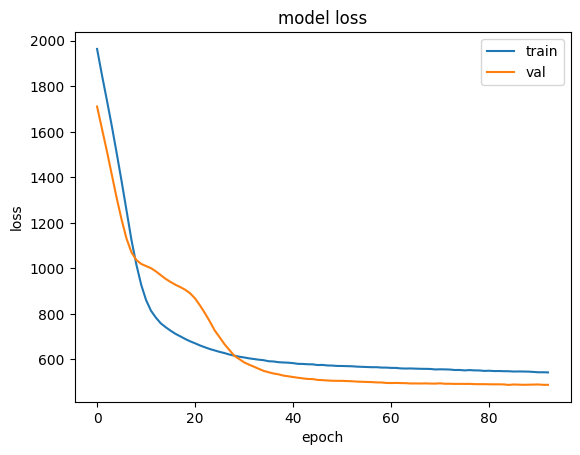

In [24]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [25]:
train_pred = vae_model.predict(train)[0]

461/461 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


In [26]:
mae_vector = get_error_term(train_pred, train, _rmse=True)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
# print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

# error_thresh = np.quantile(mae_vector, 0.99)

Avg error 0.2762226164340973
median error 0.25812292098999023
99Q: 0.5168525147438049


(array([  14.,   25.,   62.,  213.,  380.,  603.,  839.,  948., 1125.,
         906.,  740.,  813.,  721.,  569.,  522.,  961.,  759.,  571.,
         447.,  358.,  253.,  182.,  144.,  241.,  330.,  239.,  114.,
         146.,  241.,  278.,  194.,  165.,  116.,  121.,   67.,   53.,
          44.,   31.,   28.,   22.,   26.,   25.,   23.,   14.,   22.,
          17.,    9.,   13.,   14.,    4.]),
 array([0.13722132, 0.14653274, 0.15584415, 0.16515557, 0.17446698,
        0.18377841, 0.19308981, 0.20240124, 0.21171266, 0.22102407,
        0.23033549, 0.2396469 , 0.24895832, 0.25826973, 0.26758116,
        0.27689257, 0.28620398, 0.29551539, 0.30482683, 0.31413823,
        0.32344964, 0.33276108, 0.34207249, 0.35138389, 0.3606953 ,
        0.37000674, 0.37931815, 0.38862956, 0.39794099, 0.4072524 ,
        0.41656381, 0.42587522, 0.43518665, 0.44449806, 0.45380947,
        0.46312091, 0.47243232, 0.48174372, 0.49105516, 0.50036657,
        0.50967801, 0.51898938, 0.52830082, 0.5376122 , 

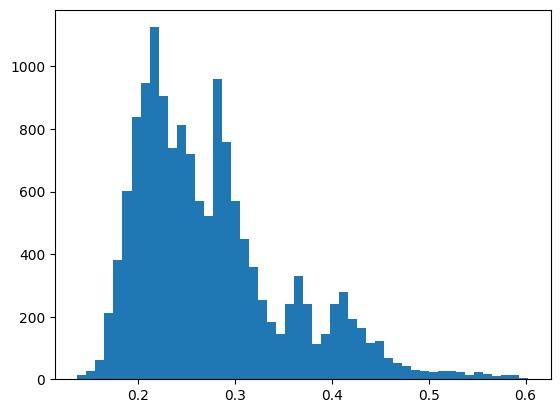

In [27]:
plt.hist(mae_vector, bins=50)

In [28]:
error_thresh = np.max(mae_vector) 
print(f'setting threshold on {error_thresh} ')

setting threshold on 0.6027921438217163 


In [29]:
#Actual ratio of anomalies 
ratio=1-np.count_nonzero(labels_of_test) / len(labels_of_test)
print(ratio)

0.1665442796299016


In [30]:
pred = vae_model.predict(test)[0]
mae_vector_test = get_error_term(pred, test, _rmse=True)
print(f'Avg error {np.mean(mae_vector_test)}\nmedian error {np.median(mae_vector_test)}')
anomalies = (mae_vector_test > (error_thresh))

np.count_nonzero(anomalies) / len(anomalies)

  1/213 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Avg error 0.5289685726165771
median error 0.5172708034515381


0.13173740637391687

(array([ 48.,  27.,  20.,  65., 173.,  90.,  68.,  86., 183., 231., 361.,
        555., 355., 218., 232., 397., 429., 412., 473., 319., 398., 481.,
        330., 150.,  80.,  38.,  28.,  25.,  28.,  21.,  18.,  15.,  11.,
          9.,   3.,   1.,  10.,  18.,  20.,  15.,  14.,  16.,  18.,  21.,
         77., 115.,  61.,  25.,  14.,   7.]),
 array([0.2866888 , 0.30056894, 0.31444907, 0.32832924, 0.34220937,
        0.3560895 , 0.36996964, 0.38384977, 0.39772993, 0.41161007,
        0.4254902 , 0.43937033, 0.45325047, 0.46713063, 0.48101076,
        0.4948909 , 0.50877106, 0.5226512 , 0.53653133, 0.55041146,
        0.5642916 , 0.57817173, 0.59205186, 0.605932  , 0.61981213,
        0.63369226, 0.64757246, 0.66145259, 0.67533273, 0.68921286,
        0.70309299, 0.71697313, 0.73085326, 0.74473339, 0.75861353,
        0.77249372, 0.78637385, 0.80025399, 0.81413412, 0.82801425,
        0.84189439, 0.85577452, 0.86965466, 0.88353479, 0.89741492,
        0.91129506, 0.92517525, 0.93905538, 0.

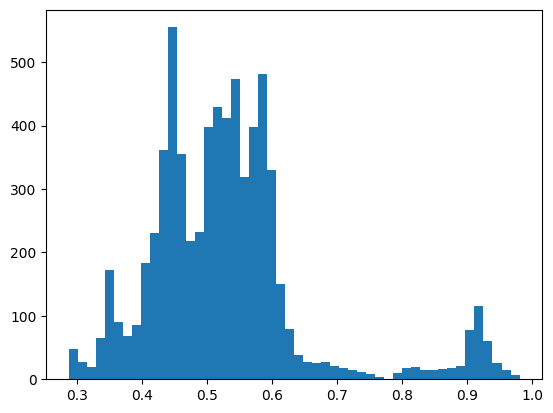

In [31]:
plt.hist(mae_vector_test, bins=50)

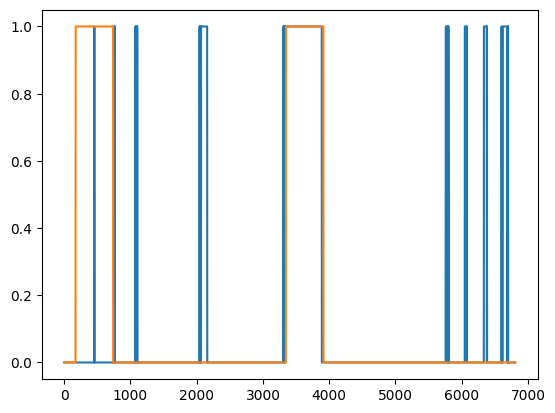

In [32]:
plt.plot(anomalies)
plt.plot(np.logical_not(labels_of_test))

In [33]:
from sklearn.metrics import classification_report
# y_test contains the labels of anomaly =1
print(classification_report(np.logical_not(labels_of_test), anomalies))

              precision    recall  f1-score   support

       False       0.90      0.94      0.92      5675
        True       0.61      0.48      0.53      1134

    accuracy                           0.86      6809
   macro avg       0.75      0.71      0.73      6809
weighted avg       0.85      0.86      0.85      6809



In [34]:
tst_data['anomaly']=anomalies
df = data_w_ts['timestamp']
ts = df.iloc[int(len(data_w_ts) * (1 - test_ratio)) :]
tst_data['timestamp']=ts
tst_data = tst_data[['timestamp','value', 'label','anomaly']]

C:\Users\99anj\AppData\Local\Temp\ipykernel_9108\3776165707.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tst_data['anomaly']=anomalies
C:\Users\99anj\AppData\Local\Temp\ipykernel_9108\3776165707.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tst_data['timestamp']=ts


Text(0.5, 1.0, 'Location of the Anomalies on the Time Series, Test Period')

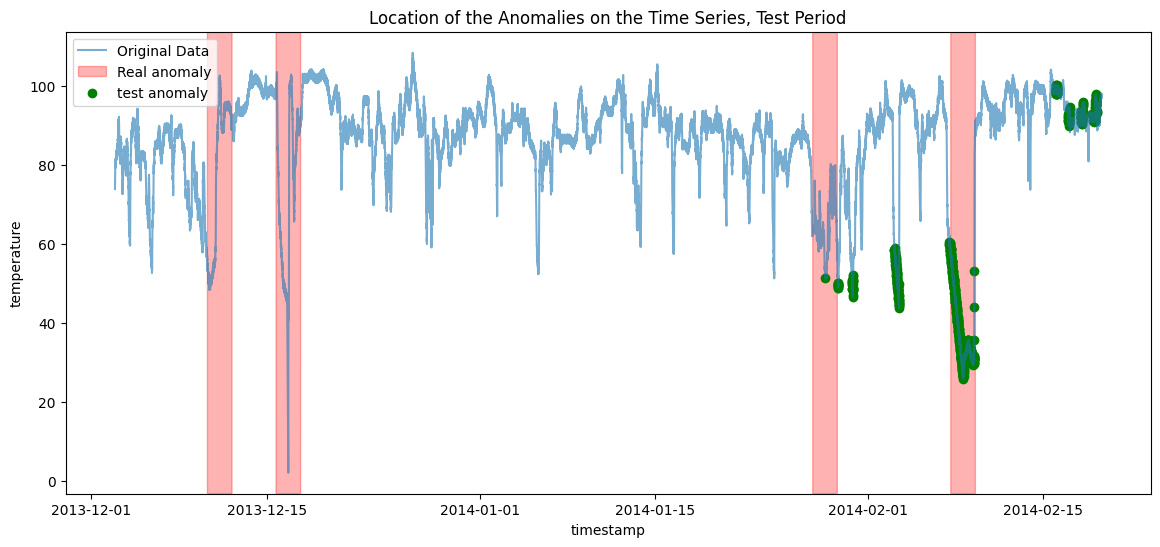

In [35]:
anomalies_ts = data_w_ts.loc[data_w_ts['label']==0, ('timestamp', 'value')]
testing = tst_data.loc[tst_data['anomaly']==True, ('timestamp', 'value')]
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data_w_ts['timestamp'], data_w_ts['value'], label='Original Data', alpha=0.6)
ax.fill_between(data_w_ts['timestamp'], 0, 1, where=np.logical_not(data_w_ts['label']), color='red', alpha=0.3, transform=ax.get_xaxis_transform(),label='Real anomaly')
#ax.scatter(anomalies_ts['timestamp'], anomalies_ts['value'], color='red', label='Real anomaly')
ax.scatter(testing['timestamp'], testing['value'], color='green', label='test anomaly')
plt.legend()
plt.xlabel("timestamp")
plt.ylabel("temperature")
plt.title("Location of the Anomalies on the Time Series, Test Period")